First, we load the neural network weights into numpy arrays.

In [31]:
import pickle

numpy_eval_save_file = "./numpy_eval.pkl"

hidden_layer_weights = []
hidden_layer_biases = []
num_hidden_layers = 0 # count of hidden layers
output_layer_weight = None
output_layer_bias = None

def load_numpy_model():
    global hidden_layer_weights, hidden_layer_biases, num_hidden_layers, output_layer_weight, output_layer_bias
    with open(numpy_eval_save_file, 'rb') as f:
        hidden_layer_weights, hidden_layer_biases, num_hidden_layers, output_layer_weight, output_layer_bias = pickle.load(f)

load_numpy_model()

This function does a CPU numpy evaluation of the trained neural network.

In [32]:
import numpy as np

def evaluate_numpy_nn(x):
    global hidden_layer_weights, hidden_layer_biases, num_hidden_layers, output_layer_weight, output_layer_bias

    # Hidden layers
    for h in range(num_hidden_layers):
        x = np.matmul(hidden_layer_weights[h], x) + hidden_layer_biases[h] # H: W*x + b
        x = np.maximum(x, 0) # ReLU
    # Output layer
    x = np.matmul(output_layer_weight, x) + output_layer_bias # Output: W*x + b
    # Log softmax
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

This function preprocesses images from HDMI by cropping and by thresholding. 

In [33]:
from skimage.measure import block_reduce
import matplotlib.pyplot as plt

def preprocess_camera_image(img_PIL, black_threshold=.20, crop_margin=0.75):
    # Crop (to square, remove timestamp)
    width, height = img_PIL.size 
    # print(str(width) + " " + str(height))
    target_size = crop_margin * height
    leftright_margin = (width - target_size) / 2
    topbottom_margin = (height - target_size) / 2
    area = (leftright_margin, topbottom_margin, width-leftright_margin, \
                   height-topbottom_margin) # rescale to square and remove time stamp
    img_PIL = img_PIL.crop(area)
#     imgplot = plt.imshow(img_PIL)
#     plt.show()
    # Convert to Numpy
    img = np.asarray(img_PIL)
        
    # Grayscale (by averaging channels)
    img_gray = np.mean(img, axis=2)
    # Treshold
    minn = np.min(img_gray)
    maxx = np.max(img_gray)
    rng = maxx-minn
    thresh = black_threshold * rng + minn
    img_thresh = img_gray < thresh
    # Downsample (using max)
    img_small = block_reduce(img_thresh, block_size=(11, 11), func=np.max)[:28,:28]
    # imgplot = plt.imshow(img_small)
    # plt.show()

    return img_small

This function carves the prediction on the hdmi output.

In [34]:
number_pixels = []

number_pixels.append([ #0
    [0, 0,   0,   0,   0],
    [0, 255, 255, 255, 0],
    [0, 255, 0,   255, 0], 
    [0, 255, 255, 255, 0],
    [0, 0,   0,   0,   0]
])

number_pixels.append([ #1
    [0, 0,   0,   0,   0],
    [0, 0,   255, 0,   0], 
    [0, 0,   255, 0,   0],
    [0, 0,   255, 0  , 0],
    [0, 0,   0,   0,   0]
])


number_pixels.append([ #2
    [0, 255,   255,   255,   0],
    [0, 0,     0,     255,   0],
    [0, 255,   255,   255,   0],
    [0, 255,   0,     0,     0],
    [0, 255,   255,   255,   0]
])

number_pixels.append([ #3
    [0, 255,   255,   255,   0],
    [0, 0,     0,     255,   0],
    [0, 255,   255,   255,   0],
    [0, 0,     0,     255,   0],
    [0, 255,   255,   255,   0]
])

number_pixels.append([ #4
    [0, 255, 0,   255,   0],
    [0, 255, 0,   255,   0],
    [0, 255, 255, 255,   0],
    [0, 0,   0,   255,   0],
    [0, 0,   0,   255,   0]
])

number_pixels.append([ #5
    [0, 255,   255,   255,  0],
    [0, 255,   0,     0,    0],
    [0, 255,   255,   255,  0],
    [0, 0,     0,     255,  0],
    [0, 255,   255,   255,  0]
])

number_pixels.append([ #6
    [0, 255,   255, 255, 0],
    [0, 255,   0,   0,   0],
    [0, 255,   255, 255, 0],
    [0, 255,   0,   255, 0],
    [0, 255,   255, 255, 0]
])

number_pixels.append([ #7
    [0, 255, 255, 255,   0],
    [0, 0,   0,   255,   0],
    [0, 0,   0,   255,   0],
    [0, 0,   0,   255  , 0],
    [0, 0,   0,   255,   0]
])

number_pixels.append([ #8
    [0, 255, 255, 255,   0],
    [0, 255, 0,   255,   0],
    [0, 255, 255, 255,   0],
    [0, 255, 0,   255  , 0],
    [0, 255, 255, 255,   0]
])

number_pixels.append([ #9
    [0, 255, 255, 255,   0],
    [0, 255, 0,   255,   0],
    [0, 255, 255, 255,   0],
    [0, 0,   0,   255  , 0],
    [0, 0,   0,   255,   0]
])

def carve_pred(frame, pred):
    index_y = 0
    counter_y = 0
    for y in range(0, 50):
        index_x = 0
        counter_x = 0
        for x in range(0, 50):
            frame_y = hdmi_in.mode.width-51+y
            frame_x = hdmi_in.mode.height-51+x
            frame[frame_x][frame_y] = number_pixels[pred][index_x][index_y]
            if(9 == counter_x):
                counter_x = 0
                index_x = index_x + 1
            else:
                counter_x = counter_x + 1
        if(9 == counter_y):
            counter_y = 0
            index_y = index_y + 1
        else:
            counter_y = counter_y + 1

Base overlay and instantiate the HDMI input and output.

In [36]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *

base = BaseOverlay("base.bit")
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out
base.download()

We'll use the default pixel format which is 24 bit-per-pixel BGR formatted data for ease of use with OpenCV.

In [38]:
hdmi_in.configure(PIXEL_RGB)
hdmi_out.configure(hdmi_in.mode, PIXEL_RGB)

hdmi_in.start()
hdmi_out.start()

We want to access or modify the frames. For that we a loop calling readframe and writeframe.

In [39]:
import PIL.Image
# import time

numframes = 600
# start = time.time()

for _ in range(numframes):
    frame = hdmi_in.readframe()
    
    image_PIL = PIL.Image.fromarray(frame)
    img_small = preprocess_camera_image(image_PIL)
    img_small = img_small.reshape(784)
    numpy_output = evaluate_numpy_nn(img_small)
    prediction = np.argmax(numpy_output)
    carve_pred(frame, prediction)
    
    hdmi_out.writeframe(frame)

# end = time.time()
# print("Frames per second:  " + str(numframes / (end - start)))

KeyboardInterrupt: 

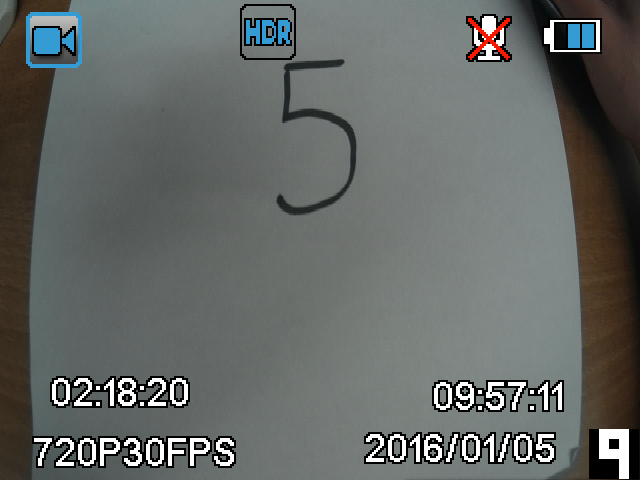

In [29]:
carve_pred(frame, prediction)
            
image_PIL = PIL.Image.fromarray(frame)
image_PIL

We need to preprocess the camera image

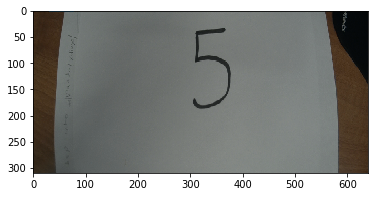

(28, 28)

In [47]:
from skimage.measure import block_reduce
import matplotlib.pyplot as plt

def preprocess_camera_image(img_PIL, black_threshold=.20, crop_margin=0.75):
    # Crop (to square, remove timestamp)
    width, height = img_PIL.size 
    # print(str(width) + " " + str(height))
    target_size = crop_margin * height
    left_margin = 0 # (width - target_size) / 2
    right_margin = 0
    top_margin = 65
    bottom_margin = 105
    area = (left_margin, top_margin, width-right_margin, \
                   height-bottom_margin) # rescale to square and remove time stamp
    img_PIL = img_PIL.crop(area)
    imgplot = plt.imshow(img_PIL)
    plt.show()
    # Convert to Numpy
    img = np.asarray(img_PIL)
        
    # Grayscale (by averaging channels)
    img_gray = np.mean(img, axis=2)
    # Treshold
    minn = np.min(img_gray)
    maxx = np.max(img_gray)
    rng = maxx-minn
    thresh = black_threshold * rng + minn
    img_thresh = img_gray < thresh
    # Downsample (using max)
    img_small = block_reduce(img_thresh, block_size=(11, 11), func=np.max)[:28,:28]
#     imgplot = plt.imshow(img_small)
#     plt.show()
    return img_small

img_small = preprocess_camera_image(image_PIL)
img_small.shape

In [23]:
img_small = img_small.reshape(784)
numpy_output = evaluate_numpy_nn(img_small)
prediction = np.argmax(numpy_output)
prediction

3

Must always stop the interfaces when you are done with them. Otherwise bad things can happen when the bitstream is reprogrammed. You can also use the HDMI interfaces in a context manager to ensure that the cleanup is always performed.

In [40]:
hdmi_out.close()
hdmi_in.close()